20:37:40 - cmdstanpy - INFO - Chain [1] start processing
20:37:40 - cmdstanpy - INFO - Chain [1] done processing


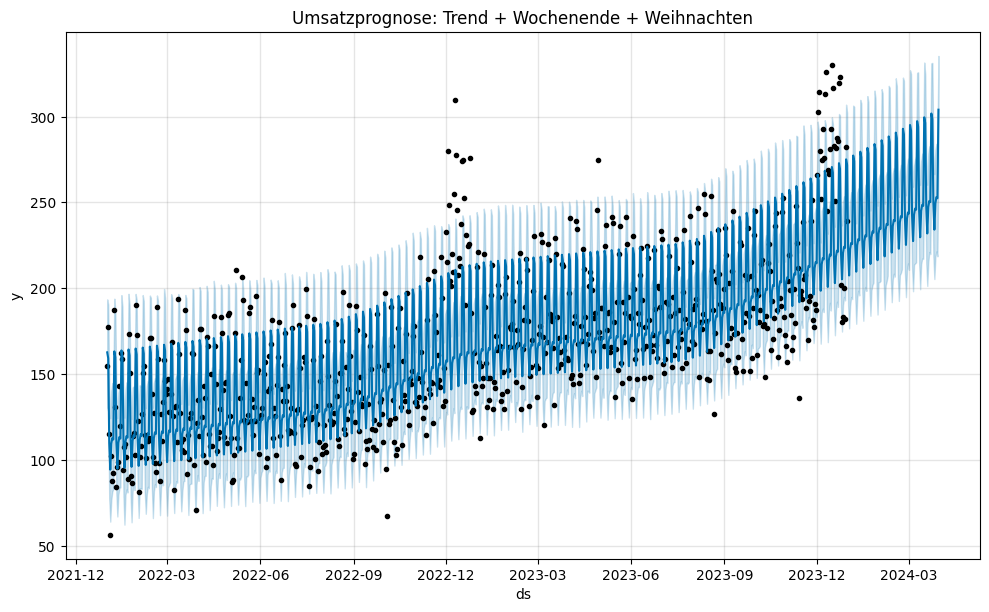

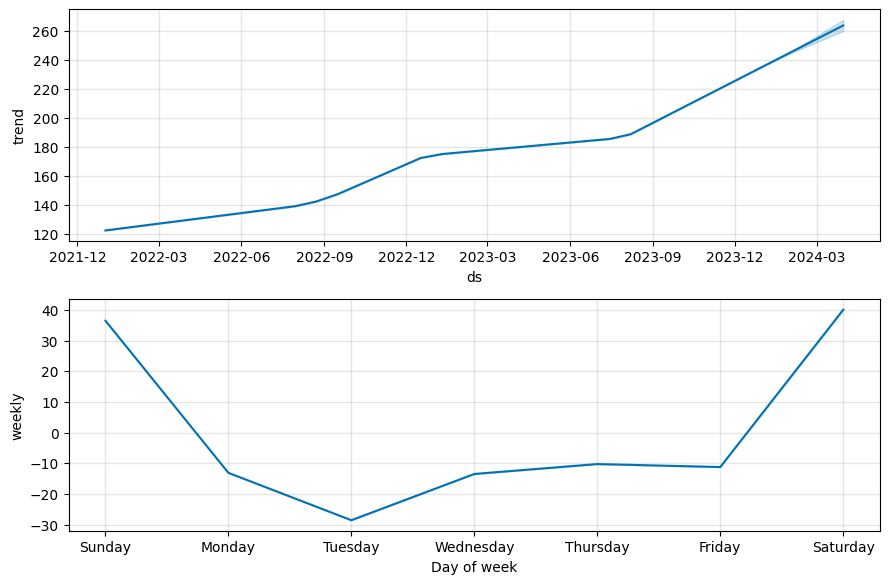

In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Realistische Daten generieren (2 Jahre) ---
# Zeitraum: 2022 bis Ende 2023
dates = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
n = len(dates)

# A. Der Trend: Lineares Wachstum + ein Sockelbetrag
trend = np.linspace(start=100, stop=200, num=n)

# B. Wochen-Muster: Wochenende ist stark, Dienstag ist schwach
# 0=Montag, 6=Sonntag
def get_weekly_pattern(day):
    if day >= 5: # Samstag (5) und Sonntag (6)
        return 50 # Bonus fürs Wochenende
    elif day == 1: # Dienstag
        return -20 # Dienstag ist oft flau im E-Commerce
    else:
        return 0

weekly_seasonality = dates.dayofweek.map(get_weekly_pattern)

# C. Jahres-Muster: Weihnachtsgeschäft (Dezember Peak)
# Wir nutzen eine Sinus-Kurve für grobe Jahreszeit + einen künstlichen Peak im Dez
yearly_seasonality = 10 * np.sin(2 * np.pi * dates.dayofyear / 365.25)

# Der "Weihnachts-Wahnsinn": Ab 1. Dez geht es hoch
christmas_bump = ((dates.month == 12) & (dates.day <= 24)).astype(int) * 80

# D. Zufallsrauschen (Noise)
noise = np.random.normal(0, 15, n)

# Alles zusammenrechnen
y = trend + weekly_seasonality + yearly_seasonality + christmas_bump + noise

# DataFrame erstellen
df = pd.DataFrame({'ds': dates, 'y': y})

# --- 2. Prophet Modell ---
# Prophet erkennt diese Muster automatisch!
m = Prophet(daily_seasonality=False) # Daily brauchen wir nicht bei Tagesdaten
m.fit(df)

# --- 3. Vorhersage (3 Monate in die Zukunft) ---
future = m.make_future_dataframe(periods=90)
forecast = m.predict(future)

# --- 4. Visualisierung ---
# A. Der Haupt-Chart
fig1 = m.plot(forecast)
plt.title("Umsatzprognose: Trend + Wochenende + Weihnachten")
plt.show()

# B. Die "Magie": Zerlegung in Komponenten
# Hier siehst du genau, wie Prophet den Trend vom Wochentag trennt
fig2 = m.plot_components(forecast)
plt.show()